In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/california-housing-competitions-technos/sample.csv
/kaggle/input/california-housing-competitions-technos/train.csv
/kaggle/input/california-housing-competitions-technos/test.csv


# モジュールの準備


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# 前処理(正規化・標準化)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# データ分割
from sklearn.model_selection import train_test_split

# 線形モデル
from sklearn.linear_model import LinearRegression

# グラフをアウトプット行に出力するためのマジックコマンド
%matplotlib inline

# データの準備と前処理
- この項目では利用するデータの用意から前処理までを紹介します。
- **「データ分析は前処理が8割」**と業界で一般的に言われているほど、前処理は非常に重要な工程です。  
AIモデルの精度は、この段階で大きく左右されるため、ここでしっかりと前処理について学習しましょう！
- 参考URL：https://xtech.nikkei.com/atcl/learning/lecture/19/00110/00001/?P=3


## データセットの読み込み(構造化データ)
- 基本的にあらかじめ用意したcsv,tsvファイルなどをpandasのread_csv関数で読み込んだりします
- 今回はkaggleに登録しているカルフォルニア住宅価格データセットを読み込みます

In [3]:
train = pd.read_csv('/kaggle/input/california-housing-competitions-technos/train.csv')
test = pd.read_csv('/kaggle/input/california-housing-competitions-technos/test.csv')
sample = pd.read_csv('/kaggle/input/california-housing-competitions-technos/sample.csv')

### 今回利用するデータ
- 今回使うデータセットのカラムは以下になります。

|カラム名|意味|
|-|-|
|MedInc|ブロックの所得中央値|
|HouseAge|ブロックの家屋年齢の中央値|
|AveRooms|1世帯当たりの平均居室数|
|AveBedrms|1世帯当たりの平均寝室数|
|Population|ブロックの人口|
|AveOccup|平均世帯人口|
|Latitude|緯度|
|Longitude|経度|
|**Price**|住宅価格(目的変数)|

### データの説明

- 1990年の米国国勢調査から得られたデータ
- 一定のエリア(ブロックグループ)で集計されている(1ブロックグループ辺り大体600人から3000人)
- レコード数は20640で欠損値はなし
- 目的変数はカルフォルニア州の住宅価格の中央値で10万ドル単位で表示している
  - 例) 4.3 → 43万ドル

In [4]:
# データの表示
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms,Price
0,0,1.4817,6.0,4.443645,1.134293,1397.0,3.350120,36.77,-119.84,417.0,1853.0,473.0,0.720
1,1,6.9133,8.0,5.976471,1.026471,862.0,2.535294,33.68,-117.80,340.0,2032.0,349.0,2.741
2,2,1.5536,25.0,4.088785,1.000000,931.0,4.350467,36.60,-120.19,214.0,875.0,214.0,0.583
3,3,1.5284,31.0,2.740088,1.008811,597.0,2.629956,34.10,-118.32,227.0,622.0,229.0,2.000
4,4,4.0815,21.0,5.166667,1.002688,1130.0,3.037634,37.79,-121.23,372.0,1922.0,373.0,1.179


In [5]:
test.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms
0,0,6.4114,15.0,7.527559,1.049869,2529.0,3.318898,33.60,-117.65,762.0,5736.0,800.0
1,1,4.1843,12.0,6.330084,1.041783,2033.0,2.831476,38.62,-120.91,718.0,4545.0,748.0
2,2,1.7411,35.0,5.369159,1.294393,909.0,4.247664,33.93,-118.23,214.0,1149.0,277.0
3,3,3.4412,39.0,4.173405,1.074573,2156.0,1.937107,37.59,-122.37,1113.0,4645.0,1196.0
4,4,7.8195,16.0,8.602349,1.058725,2142.0,3.593960,33.70,-117.98,596.0,5127.0,631.0


In [6]:
sample.head()

,id,Price
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


### データの中身を確認(探索的データ解析：EDA)
- より良い機械学習モデルを構築する際には、特徴量エンジニアリング(Feature Engineering)を必要することが多々あり、その際に深いデータの知識と理解が求められます。(例 月曜には特定の商品売上が上がる→曜日と商品を条件にフラグ化する)  
どのようなデータセットを扱っているのか、データの傾向がどのようになっているかなどを事前によく理解しておく必要があり、「探索的データ解析（EDA）」はまさしくそれを目的とした作業となります。  
EDAには様々な手法がありますが、テーブルデータの場合、最低限以下は確認しておくことをオススメします。  


**①生データ**  
**②行数、列数、列名**  
**③データの型と欠損値**  
**④基本統計量**  
**⑤目的変数と説明変数間との相関係数**  
**⑥変数の分布**  

ここから実際にpythonのコードでEDAをしていきます。

In [7]:
# ①生データ(先頭10行を表示　末尾のデータを表示する場合はtail()を使います)

train.head(10)

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms,Price
0,0,1.4817,6.0,4.443645,1.134293,1397.0,3.350120,36.77,-119.84,417.0,1853.0,473.0,0.72000
1,1,6.9133,8.0,5.976471,1.026471,862.0,2.535294,33.68,-117.80,340.0,2032.0,349.0,2.74100
2,2,1.5536,25.0,4.088785,1.000000,931.0,4.350467,36.60,-120.19,214.0,875.0,214.0,0.58300
3,3,1.5284,31.0,2.740088,1.008811,597.0,2.629956,34.10,-118.32,227.0,622.0,229.0,2.00000
4,4,4.0815,21.0,5.166667,1.002688,1130.0,3.037634,37.79,-121.23,372.0,1922.0,373.0,1.17900
5,5,4.1477,32.0,4.879098,0.956967,1264.0,2.590164,33.79,-118.32,488.0,2381.0,467.0,3.15100
6,6,4.7009,31.0,5.011905,1.047619,1046.0,2.075397,34.01,-118.43,504.0,2526.0,528.0,5.00001
7,7,4.1325,32.0,5.439619,1.085805,2152.0,2.279661,32.64,-117.07,944.0,5135.0,1025.0,1.72800
8,8,4.2011,9.0,6.045161,1.038710,1955.0,3.153226,36.22,-119.33,620.0,3748.0,644.0,1.08100
9,9,4.8750,18.0,6.028871,1.091864,1086.0,2.850394,37.50,-122.47,381.0,2297.0,416.0,3.34600


In [8]:
test.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms
0,0,6.4114,15.0,7.527559,1.049869,2529.0,3.318898,33.60,-117.65,762.0,5736.0,800.0
1,1,4.1843,12.0,6.330084,1.041783,2033.0,2.831476,38.62,-120.91,718.0,4545.0,748.0
2,2,1.7411,35.0,5.369159,1.294393,909.0,4.247664,33.93,-118.23,214.0,1149.0,277.0
3,3,3.4412,39.0,4.173405,1.074573,2156.0,1.937107,37.59,-122.37,1113.0,4645.0,1196.0
4,4,7.8195,16.0,8.602349,1.058725,2142.0,3.593960,33.70,-117.98,596.0,5127.0,631.0


In [9]:
# ②行数、列数、列名(データの行数・列数を確認する際はshape 列名を確認する際はcplumnsを利用します)

print('行数・列数の表示\n', train.shape)
print('-'* 100)
print('列名の表示\n', train.columns)

行数・列数の表示
 (16512, 13)
----------------------------------------------------------------------------------------------------
列名の表示
 Index(['id', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'Household', 'AllRooms',
       'AllBedrms', 'Price'],
      dtype='object')


In [10]:
# ③データの型と欠損値(info関数を利用します)
# int:数値型 float:小数点型 object:文字列型

print('train_列ごと欠損値の数の表示\n', train.isnull().sum())
print('-'* 100)
print('train_データの型の表示\n', train.info())

train_列ごと欠損値の数の表示
 id            0
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Household     0
AllRooms      0
AllBedrms     0
Price         0
dtype: int64
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          16512 non-null  int64  
 1   MedInc      16512 non-null  float64
 2   HouseAge    16512 non-null  float64
 3   AveRooms    16512 non-null  float64
 4   AveBedrms   16512 non-null  float64
 5   Population  16512 non-null  float64
 6   AveOccup    16512 non-null  float64
 7   Latitude    16512 non-null  float64
 8   Longitude   16512 non-null  float64
 9   Household   16512 non-null  float64
 10  AllRooms    16512 non-null  float64
 11  AllBedrms   

In [11]:
print('test_列ごと欠損値の数の表示\n', test.isnull().sum())
print('-'* 100)
print('test_データの型の表示\n', test.info())

test_列ごと欠損値の数の表示
 id            0
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Household     0
AllRooms      0
AllBedrms     0
dtype: int64
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4128 entries, 0 to 4127
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          4128 non-null   int64  
 1   MedInc      4128 non-null   float64
 2   HouseAge    4128 non-null   float64
 3   AveRooms    4128 non-null   float64
 4   AveBedrms   4128 non-null   float64
 5   Population  4128 non-null   float64
 6   AveOccup    4128 non-null   float64
 7   Latitude    4128 non-null   float64
 8   Longitude   4128 non-null   float64
 9   Household   4128 non-null   float64
 10  AllRooms    4128 non-null   float64
 11  AllBedrms   4128 non-null   flo

In [12]:
# ④基本統計量(describe関数を利用します)
# 基本統計量：データの分布の特徴を記述したり要約するための必要な指標のことです。

train.describe()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms,Price
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,8255.500000,3.864091,28.624516,5.412724,1.094586,1435.017260,3.080506,35.626523,-119.564046,501.135962,2644.170603,539.428537,2.065093
std,4766.748158,1.893244,12.597980,2.279264,0.449683,1158.151967,10.933679,2.139150,2.005033,385.650673,2213.946369,425.193556,1.152260
min,0.000000,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,2.000000,6.000000,2.000000,0.149990
25%,4127.750000,2.562500,18.000000,4.441027,1.006231,788.000000,2.430380,33.930000,-121.790000,280.000000,1446.000000,296.000000,1.194000
50%,8255.500000,3.531300,29.000000,5.224884,1.048420,1168.000000,2.821348,34.250000,-118.490000,410.000000,2116.000000,435.000000,1.793000
75%,12383.250000,4.733225,37.000000,6.047464,1.099243,1738.000000,3.290106,37.710000,-118.010000,606.000000,3154.000000,647.250000,2.645000
max,16511.000000,15.000100,52.000000,132.533333,34.066667,35682.000000,1243.333333,41.950000,-114.310000,6082.000000,39320.000000,6445.000000,5.000010


In [13]:
test.describe()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms
count,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.00000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,2063.500000,3.896990,28.699370,5.494101,1.105031,1387.31468,3.031253,35.653217,-119.592338,493.154554,2602.132994,531.775921
std,1191.795284,1.925917,12.537087,3.134380,0.560430,1022.51429,7.822054,2.123237,1.997596,368.723505,2047.102172,405.073401
min,0.000000,0.499900,2.000000,1.000000,0.500000,6.00000,0.970588,32.560000,-124.300000,1.000000,2.000000,1.000000
25%,1031.750000,2.573550,18.000000,4.438205,1.005355,784.00000,2.428501,33.950000,-121.820000,279.000000,1458.750000,295.000000
50%,2063.500000,3.559000,29.000000,5.258908,1.049650,1159.00000,2.809997,34.275000,-118.545000,408.000000,2160.500000,434.000000
75%,3095.250000,4.802475,37.000000,6.072188,1.100000,1682.25000,3.250000,37.720000,-118.010000,597.250000,3113.000000,644.000000
max,4127.000000,15.000100,52.000000,141.909091,25.636364,11956.00000,502.461538,41.840000,-114.470000,4930.000000,27870.000000,5419.000000


- describe()の項目のそれぞれの意味は下記の通りです

|カラム名|意味|
|-|-|
|count|要素の個数|
|mean|算術平均|
|std|標準偏差|
|min|最小値|
|max|最大値|
|50%|中央値(median)|
|25%|1/4分位数|
|75%|3/4分位数|

In [14]:
# ⑤目的変数と説明変数間との相関係数(corr関数を利用します)
# 相関係数：２つの変数間にどの程度関係があるかを示す統計量。-1～1までの数値を取り絶対値が大きいほど関係性が強いと言えます。

# 下記の引数を設定することでそれぞれの相関係数を確認できます
    # 'pearson': ピアソンの積率相関係数（デフォルト）
    # 'kendall': ケンドールの順位相関係数
    # 'spearman': スピアマンの順位相関係数

corr_train = train.corr()
corr_train

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms,Price
id,1.000000,-0.009420,0.003905,0.013098,0.015765,-0.014485,0.002524,-0.012313,0.015105,-0.023855,-0.020528,-0.022428,-0.010626
MedInc,-0.009420,1.000000,-0.113804,0.358173,-0.062493,0.004353,0.022023,-0.076643,-0.019501,0.014794,0.198840,-0.006185,0.689659
HouseAge,0.003905,-0.113804,1.000000,-0.161266,-0.080613,-0.295541,0.012206,0.010653,-0.109873,-0.307466,-0.362083,-0.324896,0.108626
AveRooms,0.013098,0.358173,-0.161266,1.000000,0.823477,-0.071238,-0.010545,0.111456,-0.033410,-0.077752,0.147319,0.004784,0.157994
AveBedrms,0.015765,-0.062493,-0.080613,0.823477,1.000000,-0.063942,-0.008050,0.069299,0.012471,-0.052523,0.030278,0.047228,-0.058170
Population,-0.014485,0.004353,-0.295541,-0.071238,-0.063942,1.000000,0.066149,-0.106416,0.099824,0.907647,0.855772,0.879003,-0.027441
AveOccup,0.002524,0.022023,0.012206,-0.010545,-0.008050,0.066149,1.000000,0.005914,0.001650,-0.025789,-0.023386,-0.026731,-0.027454
Latitude,-0.012313,-0.076643,0.010653,0.111456,0.069299,-0.106416,0.005914,1.000000,-0.924753,-0.068901,-0.035012,-0.064910,-0.143970
Longitude,0.015105,-0.019501,-0.109873,-0.033410,0.012471,0.099824,0.001650,-0.924753,1.000000,0.055629,0.044776,0.068808,-0.046754
Household,-0.023855,0.014794,-0.307466,-0.077752,-0.052523,0.907647,-0.025789,-0.068901,0.055629,1.000000,0.920225,0.980115,0.063245


In [15]:
corr_test = test.corr()
corr_test

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms
id,1.000000,-0.008831,-0.016254,0.024425,0.029367,-0.020385,-0.000563,0.037816,-0.032163,-0.008211,-0.005726,-0.002533
MedInc,-0.008831,1.000000,-0.139821,0.248273,-0.061854,0.007659,0.001941,-0.092559,0.002087,0.006109,0.195754,-0.015727
HouseAge,-0.016254,-0.139821,1.000000,-0.136097,-0.070112,-0.301205,0.019375,0.013219,-0.101375,-0.283935,-0.358452,-0.302074
AveRooms,0.024425,0.248273,-0.136097,1.000000,0.906826,-0.080007,0.017579,0.095551,-0.011185,-0.092872,0.099796,-0.010989
AveBedrms,0.029367,-0.061854,-0.070112,0.906826,1.000000,-0.076860,0.001508,0.072297,0.016629,-0.063773,0.028113,0.043395
Population,-0.020385,0.007659,-0.301205,-0.080007,-0.076860,1.000000,0.094561,-0.119833,0.099697,0.907702,0.864623,0.875621
AveOccup,-0.000563,0.001941,0.019375,0.017579,0.001508,0.094561,1.000000,-0.017448,0.007154,-0.037303,-0.032609,-0.038815
Latitude,0.037816,-0.092559,0.013219,0.095551,0.072297,-0.119833,-0.017448,1.000000,-0.924302,-0.079872,-0.040717,-0.072147
Longitude,-0.032163,0.002087,-0.101375,-0.011185,0.016629,0.099697,0.007154,-0.924302,1.000000,0.053777,0.043542,0.066421
Household,-0.008211,0.006109,-0.283935,-0.092872,-0.063773,0.907702,-0.037303,-0.079872,0.053777,1.000000,0.911000,0.978575


- MedInc(ブロックの所得中央値)とPrice(住宅価格)に**0.688075**とかなりの正の相関があることが見て取れます。  
- 解釈：この場合「収入が高いほどより良い家に住む傾向にあるのでは？」と考えることができます。


<Axes: >

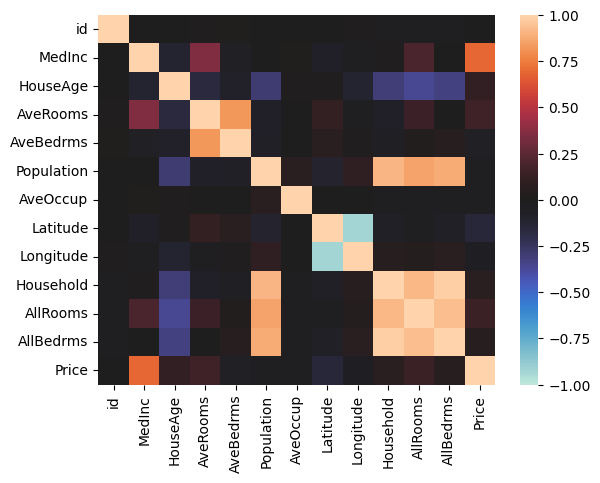

In [16]:
# sns.heatmapを使うことでヒートマップでも相関関係を確認できます
# vmax・vmin：数値の範囲　center：colormapの中心とする値
sns.heatmap(corr_train, vmax=1, vmin=-1, center=0)

<Axes: >

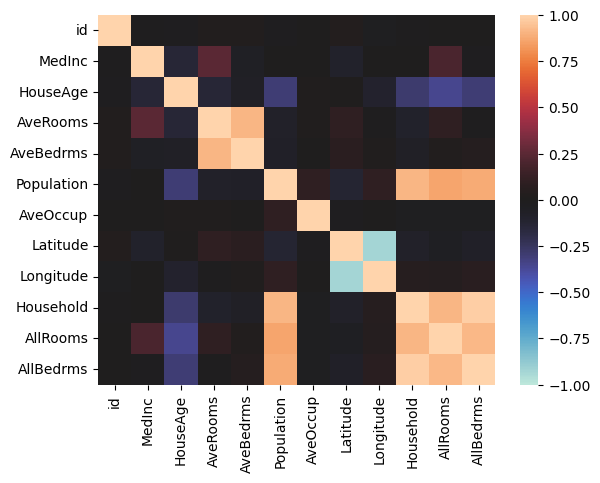

In [17]:
sns.heatmap(corr_test, vmax=1, vmin=-1, center=0)

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>,
        <Axes: title={'center': 'Latitude'}>],
       [<Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Household'}>,
        <Axes: title={'center': 'AllRooms'}>,
        <Axes: title={'center': 'AllBedrms'}>],
       [<Axes: title={'center': 'Price'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

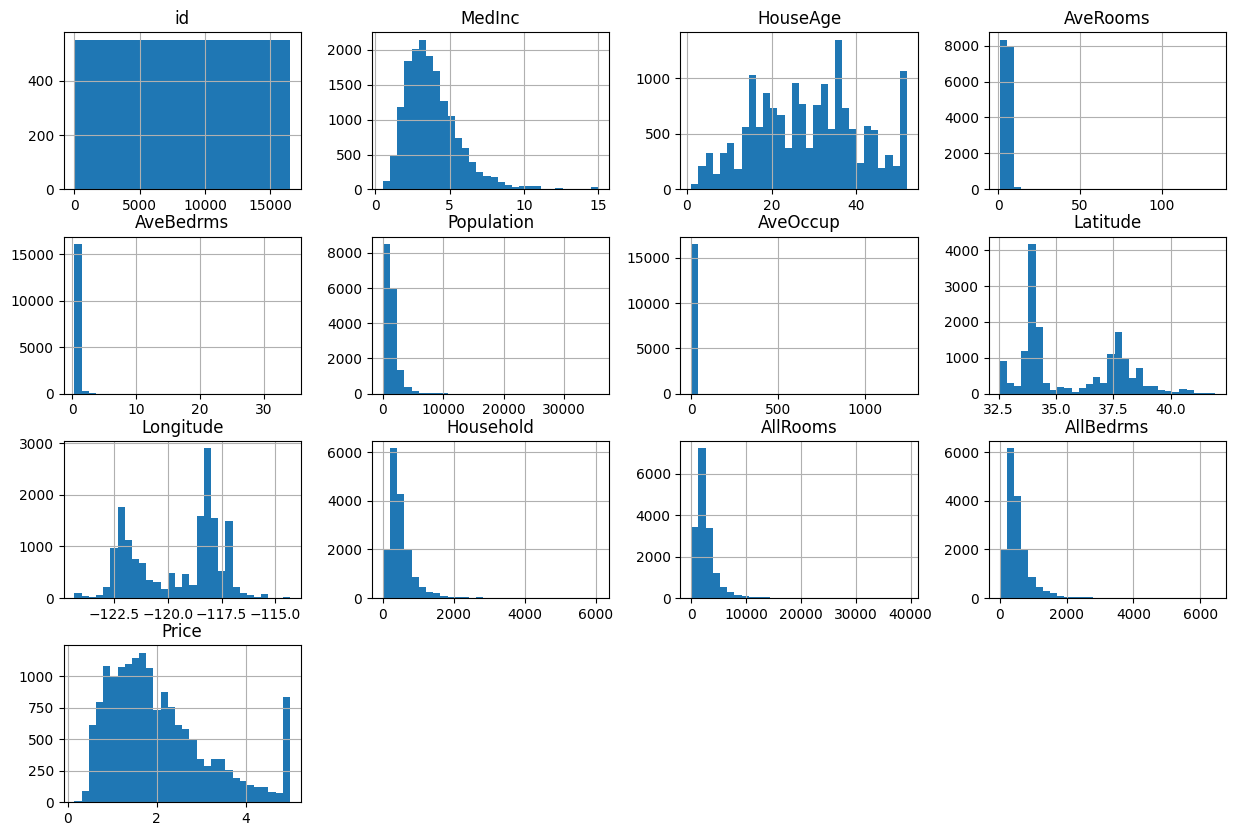

In [18]:
# ⑥変数の分布(今回はヒストグラムで確認してみます)

train.hist(bins=30, figsize=(15, 10))

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>],
       [<Axes: title={'center': 'AveRooms'}>,
        <Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>],
       [<Axes: title={'center': 'AveOccup'}>,
        <Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>],
       [<Axes: title={'center': 'Household'}>,
        <Axes: title={'center': 'AllRooms'}>,
        <Axes: title={'center': 'AllBedrms'}>]], dtype=object)

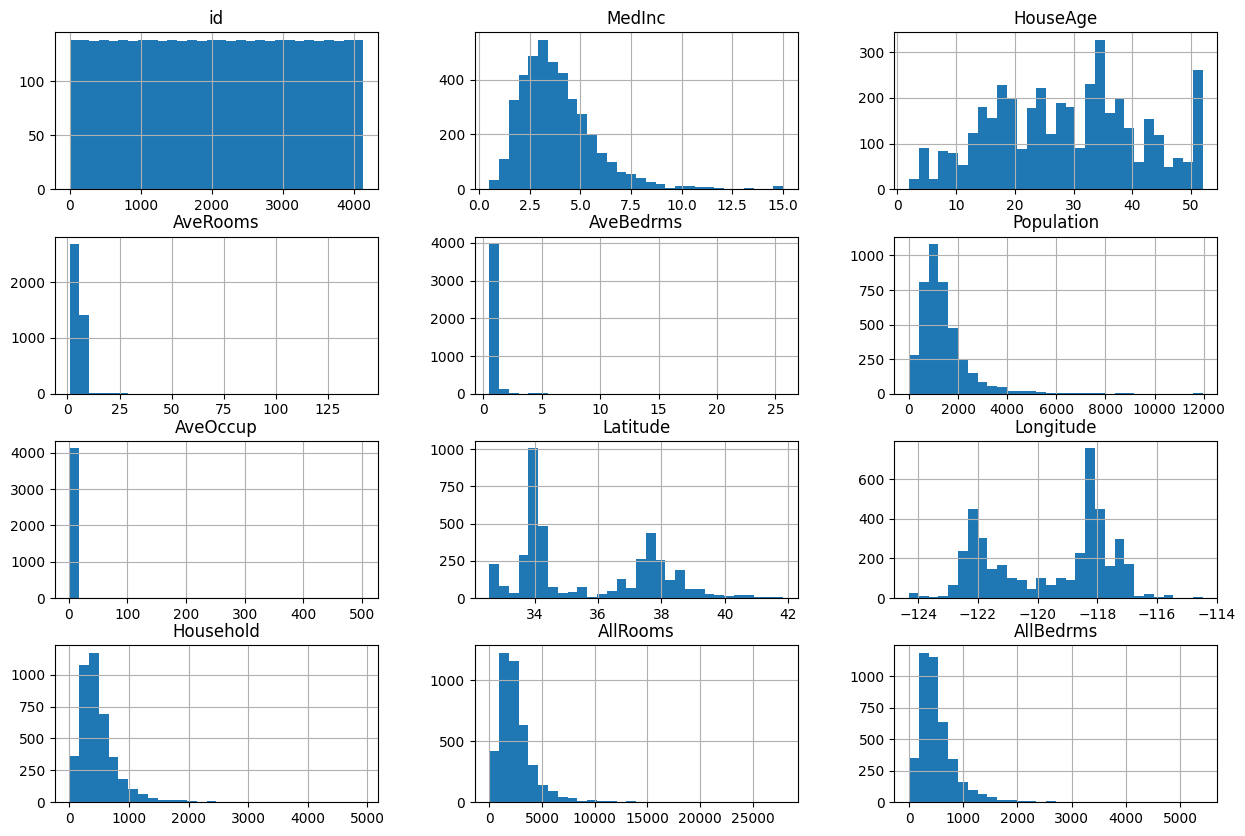

In [19]:
test.hist(bins=30, figsize=(15, 10))

<Axes: >

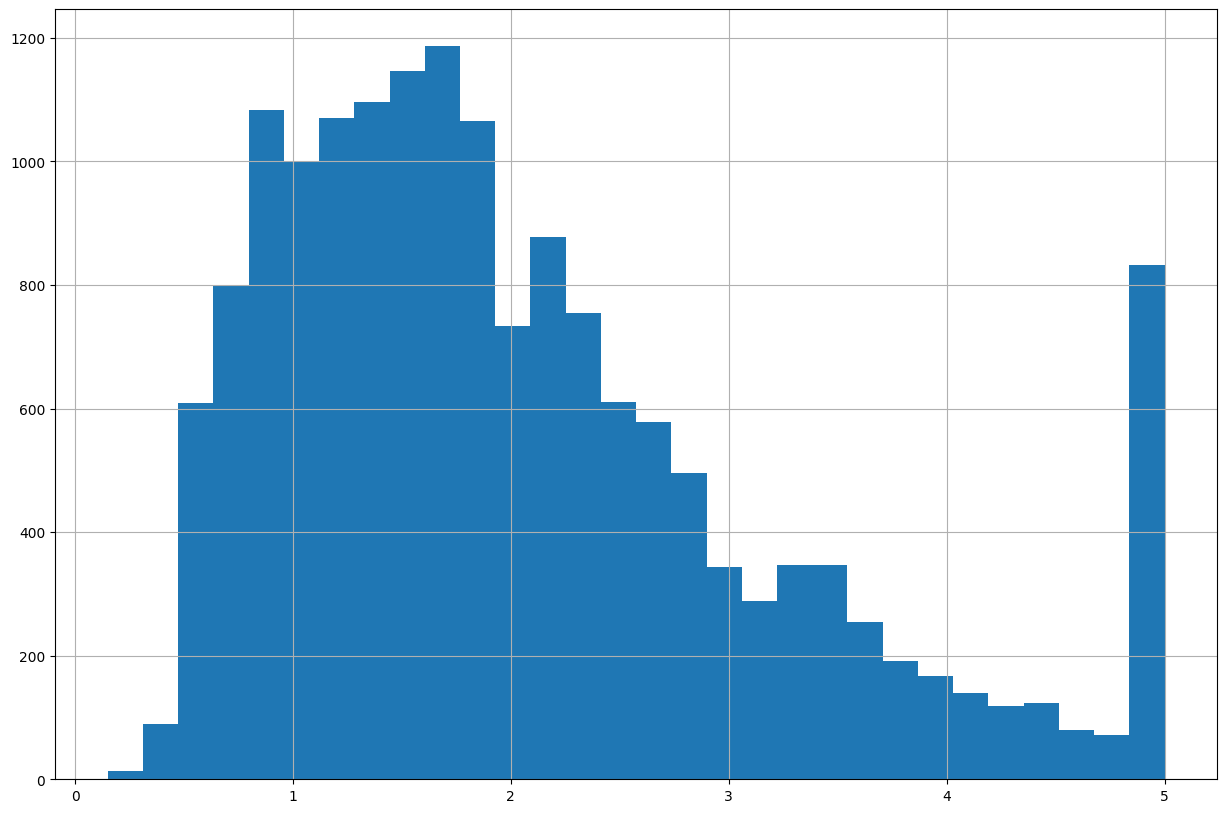

In [20]:
# Price(目的変数)に着目してみます
# 一番右のバーが不自然に突出していることが確認できます
train["Price"].hist(bins=30, figsize=(15, 10))

In [21]:
# 最大値の個数を確認
# queryメソッドで条件に沿う行を抽出できます
print(len(train.query('Price == 5.00001')))

763


- 最大値のデータが763個存在していることが確認できました。多くのデータがこうして一致するとは現実的に考えづらいため、国勢調査において5.00001以上のデータとして処理されていると考えられます。  
→AIモデルが**5.00001より大きい数値を出力した場合は5.00001に丸める処理**を入れた方がよさそうです。

## 前処理
- データの中身を確認したところで、次はデータの前処理を行っていきます。

- 前処理が必要な理由として以下のようなことが挙げられます。
  1. 機械学習のモデルは文字列データではなく数値データを渡す必要があるため(モデルによっては文字列データでも利用可能なものがあります **catboost**)
  2. 欠損値があるデータだと学習ができないモデルが存在するため(モデルによっては欠損値があっても利用可能なものもあります)
  3. 機械学習モデルの精度を向上させるため  
  etc


- 今回は以下の前処理の方法について簡単に紹介します。
  - **①欠損値の処理(削除・補完)**
      - 目的：データセットをモデルの学習に適した形式にする
  - **②カテゴリデータのエンコーディング**
      - 目的：文字列などのカテゴリデータを数値データに変換し、モデルが理解できる形式にする
  - **③データのスケーリング(標準化・正規化)**
    - 目的：特徴量の尺度を揃えることで、モデルの収束速度や性能を改善させる
  - **④特徴量選択・生成**
    - 目的：特徴量同士を組み合わせることで新たな特徴量を作成したり、無関係な特徴量や冗長な特徴量を除外することで、モデルの品質や精度を向上させる

### ①欠損値の処理(削除・補完)
- AIモデルが学習できるようにするために欠損値(null)があるデータを変換、もしくは削除をします。
- ただ欠損値の処理をする際にはそのデータが「なぜ欠損しているか」について考える必要があります。nullに対して意味がない場合は特に気にせず補完・削除をして良いですが、欠損自体に意味がある場合はそこに考慮して処理を行う必要があります。


- 意味のある欠損が生じるケース
  1. **セレクションバイアス(選択性バイアス)**：データが特定の条件や基準に基づいて収集されるため、欠損が発生することがあります。例えば、ある年齢層の回答者がアンケートに回答しない傾向がある場合、年齢に関連した欠損が発生します。
  2. **時間依存の欠損**：時系列データの場合、特定の期間において欠損が発生することがあります。例えば、気象データの収集で機器の故障が発生し、一定期間のデータが欠落する場合です。


- 欠損値の処理にはpandasのdrop,dropna,fillna関数を利用すると簡単に実装することができます。
  - drop：指定した行・列の削除ができます。
  - dropna：欠損値を一括削除することができます。
  - fillna：欠損値の穴埋めをすることができます。

In [22]:
# 元データに欠損が存在しないためダミーデータを作成します
d = {'name': ["Sato", np.nan, "Tanaka"], 'age': [24, 30, np.nan],
     'state': ["Tokyo", "Osaka", "Kyoto"], 'other': [np.nan, np.nan, np.nan]}
data = pd.DataFrame(d)
data

,name,age,state,other
0,Sato,24.0,Tokyo,NaN
1,NaN,30.0,Osaka,NaN
2,Tanaka,NaN,Kyoto,NaN


In [23]:
# 列ごとの欠損値の個数を表示
# isnull関数とsum関数を利用することで列ごとの欠損数が分かります

data.isnull().sum()

name     1
age      1
state    0
other    3
dtype: int64

In [24]:
# drop関数を用いて2行目を削除してみます
data.drop(index=1)

,name,age,state,other
0,Sato,24.0,Tokyo,NaN
2,Tanaka,NaN,Kyoto,NaN


In [25]:
# drop関数を用いてother列を削除してみます
data.drop(columns="other")

,name,age,state
0,Sato,24.0,Tokyo
1,NaN,30.0,Osaka
2,Tanaka,NaN,Kyoto


In [26]:
# dropna関数を用いて欠損値がある行をまとめて削除してみます
# axis=0で行、axis=1で列を指定できます。
data.dropna(axis=0)

,name,age,state,other


In [27]:
# 欠損値が存在する列をまとめて削除
data.dropna(axis=1)

,state
0,Tokyo
1,Osaka
2,Kyoto


In [28]:
# fillna関数を使ってage列の欠損値に平均値を代入してみます
data['age'].fillna(data['age'].mean())

0    24.0
1    30.0
2    27.0
Name: age, dtype: float64

In [29]:
# fillna関数を使ってother列に「その他」を代入してみます(文字列も代入可)
data['other'].fillna("その他")

0    その他
1    その他
2    その他
Name: other, dtype: object

### ②カテゴリデータのエンコーディング
- 文字列型や日付型などのカテゴリ変数は多くの機械学習の手法においてそのまま分析に活用することはできません。そこでカテゴリカルデータを数値データに変換するエンコーディング処理を行う必要があります。

- 主なエンコーディングの手法として下記があります
  1. **One-hot Encding**：各カテゴリをバイナリ変換(0または1)に変換する手法。例えば'赤'、'青'、'黄'というカテゴリがある場合、赤=[1,, 0]、青=[0, 1, 0]、黄=[0, 0, 1]のようになります。
  2. **Label Encoding**：各カテゴリに一意の整数値を割り当てる手法。例えば'赤'、'青'、'黄'というカテゴリがある場合、それぞれに1、2、3という整数が割り当てられます。
  3. **Count Encoding(Frequency Encoding)**：カテゴリが出現する回数でエンコードする手法。カテゴリの頻度に意味がある場合に役立ちます。
  4. **Target Encoding**：ラベルごとに目的変数の統計量(通常は平均値)を計算し、その値を変数として利用する手法。データによっては強力ですが、目的変数をエンコードに利用するためリークの問題があり取り扱いが難しい手法です。

- 今回の講義ではOne-hot EncodingとLabel Encodingを使ってみます！

In [30]:
# 元データにカテゴリデータが存在しないためダミーデータを作成します
d = {'name': ["Sato", "Suzuki", "Tanaka", "Sato"], 'age': [24, 30, 40, 25]}
data = pd.DataFrame(d)
data

,name,age
0,Sato,24
1,Suzuki,30
2,Tanaka,40
3,Sato,25


In [31]:
# One-hot Encodingの実装
# pandasのget_dummiesを利用します

pd.get_dummies(data['name'])

,Sato,Suzuki,Tanaka
0,True,False,False
1,False,True,False
2,False,False,True
3,True,False,False


- 多重共線性を防ぐために、**drop_firstオプションをTrue**に設定することをお勧めします。
  - **多重共線性**：説明変数間に高い相関がある場合、線形回帰モデルなどの統計モデルで回帰係数の推定が不安定になり、モデルの解釈が難しくなる現象

上記の例では、Suzuki=0、Tanaka=0の場合、必ずSato=1となるため、多重共線性が発生します。   
この問題を解決するために、バイナリ列のうち1つを削除する方法があります。  
例えば、3つのカテゴリが存在する場合、2つのカテゴリ分の列があれば、残りのカテゴリは他の2つのカテゴリの値がそれぞれ0であることで表現できます。  
下記の例では、SatoはSuzuki=0、Tanaka=0で表現されています。

In [32]:
# drop_first=Trueを追加
pd.get_dummies(data['name'], drop_first=True)

,Suzuki,Tanaka
0,False,False
1,True,False
2,False,True
3,False,False


In [33]:
# Label Encodingの実装
# scikit-learnのLabelEncoderを利用します
# Label Encodingは列の中身を辞書順に並び替えた順で、「0」から始まる整数に置き換えます

from sklearn.preprocessing import LabelEncoder

# LabelEncoderのインスタンス作成
le = LabelEncoder()

# LabelEncoderを使いたい対象のデータの読み込み
le.fit(data['name'])

# transformでデータの変換を実施
data['name_変換後'] = le.transform(data['name'])
data

,name,age,name_変換後
0,Sato,24,0
1,Suzuki,30,1
2,Tanaka,40,2
3,Sato,25,0


**※Label Encoderの注意事項**
- **決定木以外のアルゴリズムには使わない**ようにしましょう。
- カテゴリ変数をLabel Encodingで数値変数にしてもその**数値変数には「数値的な意味」は存在しません！**
  - 「Tanaka：2」が「Suzuki：1」の2倍大きいわけではありません。
- 決定木であればあくまでその数字が何回出現したかで比較することができるので問題なく利用することができます。

### ③データのスケーリング(標準化・正規化)
- **スケーリング**：特徴量の取りうる値の範囲を変更することや、異なる特徴量間の尺度を統一すること
- 機械学習モデルを作成する際に、スケーリングを行うべき場合もあれば、行わなくても問題ない場合もあります。  
その判断基準は、**「特徴量の尺度の違いが機械学習アルゴリズムにどの程度影響を与えるか」**で決定できます。



|スケーリングが重要なアルゴリズム|スケーリングがあまり重要でないアルゴリズム|
|-|-|
|k-最近傍法 (k-Nearest Neighbors)|決定木 (Decision Trees)|
|サポートベクターマシン (Support Vector Machines)|ランダムフォレスト (Random Forests)|
|主成分分析 (Principal Component Analysis)|1世帯当たりの平均居室数|
|k-平均法 (k-Means Clustering)|勾配ブースティング決定木(Gradient Boosting Decision Tree)|
|ニューラルネットワーク (Neural Networks)|ナイーブベイズ (Naive Bayes)|
|線形回帰 (Linear Regression)||
|ロジスティック回帰 (Logistic Regression)||

- 上記の表に示すように、特徴量スケーリングが重要なアルゴリズムは、主に**距離に基づいて計算するものや、勾配降下法を用いて最適化を行うもの**です。
- 一方で、スケーリングがあまり重要でないアルゴリズムは、主に**決定木ベース**のアルゴリズムです。これらのアルゴリズムは、データの構造を利用して学習を行うため、特徴量の尺度の影響を受けにくいです。

スケーリングの代表的な手法として下記があります。  
pythonでの実装例を見ながらそれぞれの特徴を見ていきましょう！

- **正規化(Min-Max normalization)**
- **標準化(standardization)**

- **正規化**：データの最大値と最小値が分かっている場合に有効で、データを0から1の範囲内にスケーリングする手法。
    - 外れ値に弱いという特徴があり、大きい外れ値がある場合は標準化の方が優れています。

正規化の式：
$$
x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}
$$


In [34]:
# データセットを使って正規化の実装を行います
# 改めてデータの確認
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms,Price
0,0,1.4817,6.0,4.443645,1.134293,1397.0,3.350120,36.77,-119.84,417.0,1853.0,473.0,0.720
1,1,6.9133,8.0,5.976471,1.026471,862.0,2.535294,33.68,-117.80,340.0,2032.0,349.0,2.741
2,2,1.5536,25.0,4.088785,1.000000,931.0,4.350467,36.60,-120.19,214.0,875.0,214.0,0.583
3,3,1.5284,31.0,2.740088,1.008811,597.0,2.629956,34.10,-118.32,227.0,622.0,229.0,2.000
4,4,4.0815,21.0,5.166667,1.002688,1130.0,3.037634,37.79,-121.23,372.0,1922.0,373.0,1.179


In [35]:
# MedIncとPopulationに対して正規化を行ってみます。

# min-maxスケーリングのimport
from sklearn.preprocessing import MinMaxScaler

# MedIncとPopulationのデータの抽出
min_max_df = train[["MedInc", "Population"]]

# MinMaxScalerのインスタンス化
minmax_sc = MinMaxScaler()

# transformで正規化の変換を実施
min_max_df["正規化後_MedInc"] = minmax_sc.fit_transform(min_max_df["MedInc"].values.reshape(-1, 1))
min_max_df["正規化後_Population"] = minmax_sc.fit_transform(min_max_df["Population"].values.reshape(-1, 1))

# データの表示
min_max_df.head()

/tmp/ipykernel_20/3924546163.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_max_df["正規化後_MedInc"] = minmax_sc.fit_transform(min_max_df["MedInc"].values.reshape(-1, 1))
/tmp/ipykernel_20/3924546163.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_max_df["正規化後_Population"] = minmax_sc.fit_transform(min_max_df["Population"].values.reshape(-1, 1))


,MedInc,Population,正規化後_MedInc,正規化後_Population
0,1.4817,1397.0,0.067709,0.039071
1,6.9133,862.0,0.442297,0.024076
2,1.5536,931.0,0.072668,0.026010
3,1.5284,597.0,0.070930,0.016648
4,4.0815,1130.0,0.247003,0.031587


In [36]:
# データの最小値と最大値を確認
min_max_df[["正規化後_MedInc","正規化後_Population"]].describe()

,正規化後_MedInc,正規化後_Population
count,16512.000000,16512.000000
mean,0.232010,0.040136
std,0.130567,0.032460
min,0.000000,0.000000
25%,0.142246,0.022002
50%,0.209059,0.032652
75%,0.291949,0.048628
max,1.000000,1.000000


array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'Population'}>],
       [<Axes: title={'center': '正規化後_MedInc'}>,
        <Axes: title={'center': '正規化後_Population'}>]], dtype=object)

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 35215 (\N{CJK UNIFIED IDEOGRAPH-898F}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35215 

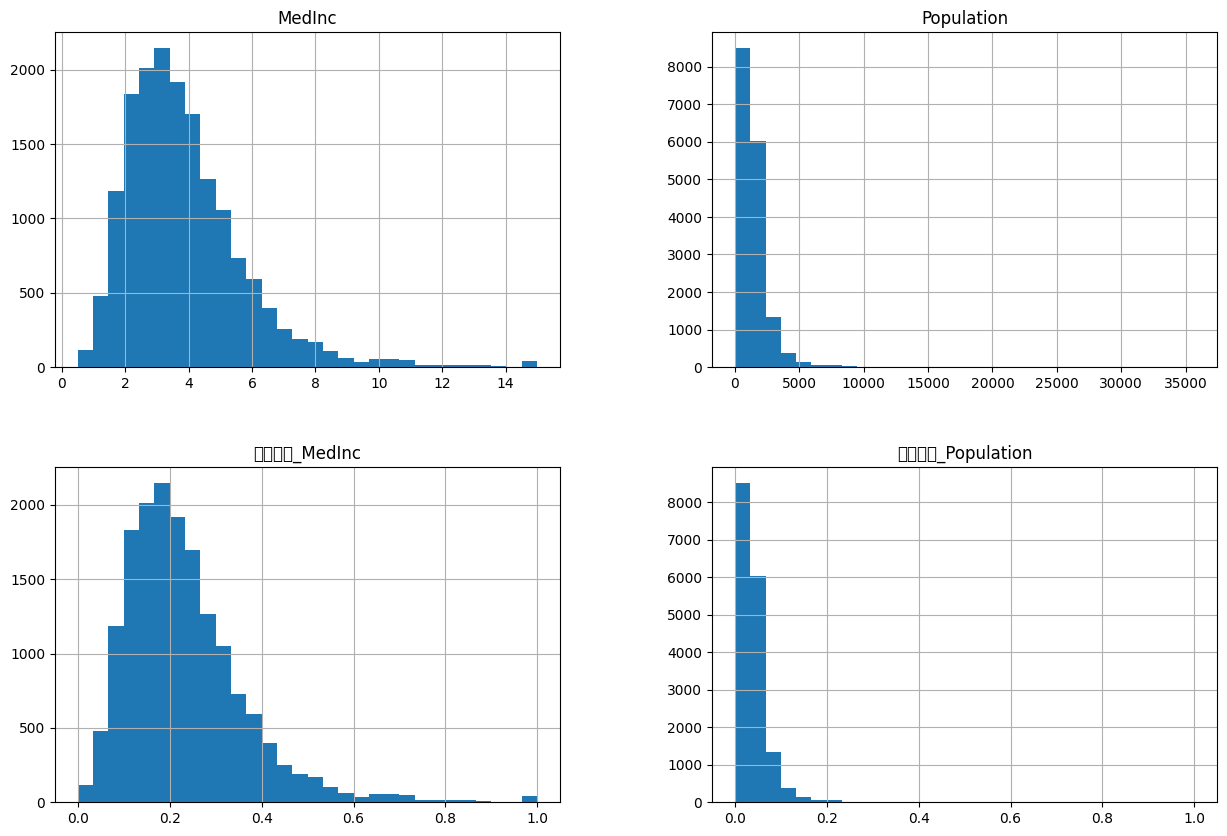

In [37]:
# データの分布をヒストグラムで確認
min_max_df.hist(bins=30, figsize=(15, 10))

- **標準化**：データが正規分布に従っている場合に有効で、データにおける平均を0、分散を1になるように値を変換する手法。
    - データの最大値と最小値が不明確な場合でも用いることができるため、正規化よりも使用される場合が多いです。

標準化の式：

$$
x_{normalized} = \frac{x - \mu}{\sigma}
$$


- μは平均値、σは標準偏差を表しています。

In [38]:
# データセットを使って標準化の実装を行います
# 改めてデータの確認
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms,Price
0,0,1.4817,6.0,4.443645,1.134293,1397.0,3.350120,36.77,-119.84,417.0,1853.0,473.0,0.720
1,1,6.9133,8.0,5.976471,1.026471,862.0,2.535294,33.68,-117.80,340.0,2032.0,349.0,2.741
2,2,1.5536,25.0,4.088785,1.000000,931.0,4.350467,36.60,-120.19,214.0,875.0,214.0,0.583
3,3,1.5284,31.0,2.740088,1.008811,597.0,2.629956,34.10,-118.32,227.0,622.0,229.0,2.000
4,4,4.0815,21.0,5.166667,1.002688,1130.0,3.037634,37.79,-121.23,372.0,1922.0,373.0,1.179


In [39]:
# MedIncとPopulationに対して標準化を行ってみます。

# StandardScalerのimport
from sklearn.preprocessing import StandardScaler

# MedIncとPopulationのデータの抽出
standard_df = train[["MedInc", "Population"]]

#インスタンス (平均=0, 標準偏差=1)
standard_sc = StandardScaler()

# transformで正規化の変換を実施
standard_df["標準化後_MedInc"] = standard_sc.fit_transform(standard_df["MedInc"].values.reshape(-1, 1))
standard_df["標準化後_Population"] = standard_sc.fit_transform(standard_df["Population"].values.reshape(-1, 1))

# データの表示
standard_df.head()

/tmp/ipykernel_20/983225279.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_df["標準化後_MedInc"] = standard_sc.fit_transform(standard_df["MedInc"].values.reshape(-1, 1))
/tmp/ipykernel_20/983225279.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_df["標準化後_Population"] = standard_sc.fit_transform(standard_df["Population"].values.reshape(-1, 1))


,MedInc,Population,標準化後_MedInc,標準化後_Population
0,1.4817,1397.0,-1.258403,-0.032827
1,6.9133,862.0,1.610623,-0.494784
2,1.5536,931.0,-1.220425,-0.435204
3,1.5284,597.0,-1.233736,-0.723603
4,4.0815,1130.0,0.114837,-0.263373


In [40]:
# 平均値と分散を計算

print('標準化後_MedInc：平均', standard_df["標準化後_MedInc"].mean())
print('標準化後_MedInc：分散', standard_df["標準化後_MedInc"].var())
print('-' * 100)
print('標準化後_Population：平均', standard_df["標準化後_Population"].mean())
print('標準化後_Population：分散', standard_df["標準化後_Population"].var())

標準化後_MedInc：平均 -5.2068599216916256e-17
標準化後_MedInc：分散 1.0000605656834838
----------------------------------------------------------------------------------------------------
標準化後_Population：平均 -5.045490296019364e-17
標準化後_Population：分散 1.0000605656834836


array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'Population'}>],
       [<Axes: title={'center': '標準化後_MedInc'}>,
        <Axes: title={'center': '標準化後_Population'}>]], dtype=object)

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28310 

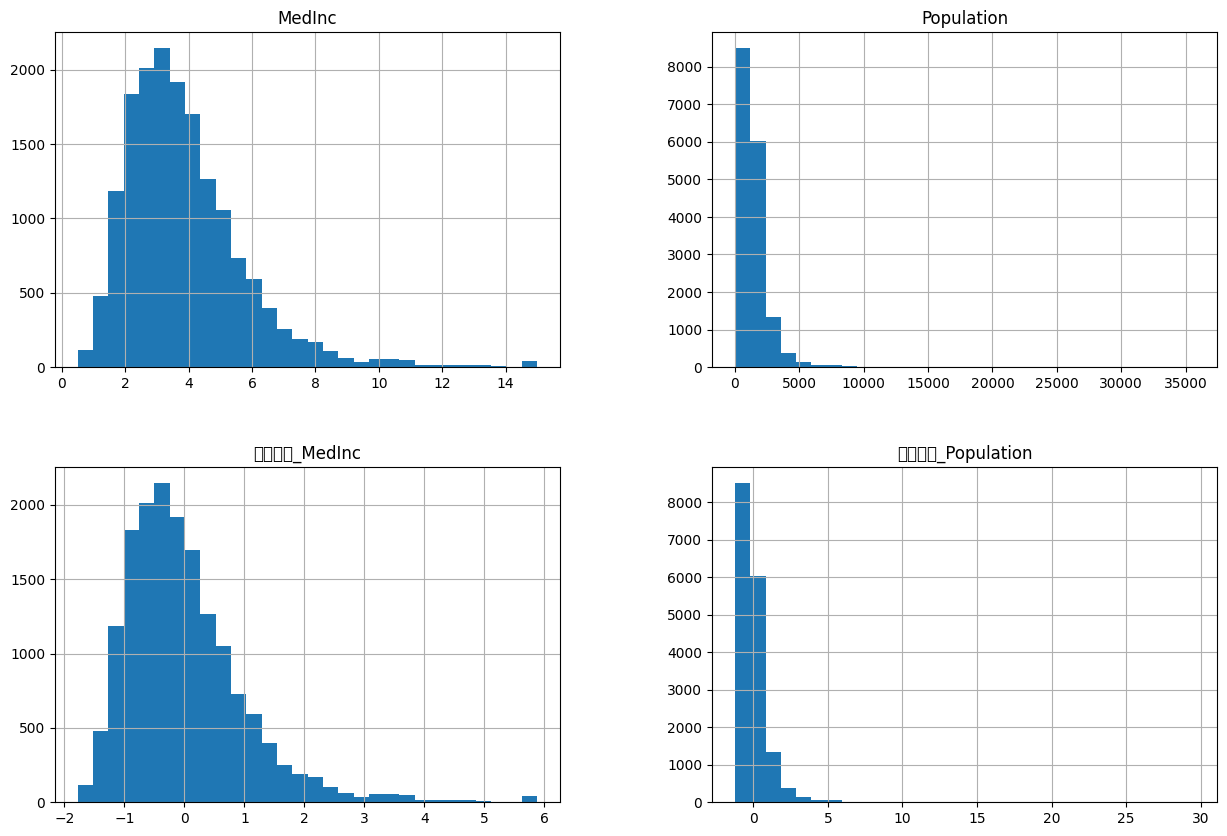

In [41]:
# データの分布をヒストグラムで確認
standard_df.hist(bins=30, figsize=(15, 10))

### ④特徴量選択・生成
- **特徴量選択**：データセット内の関連性のある特徴量を選択し、無関係な特徴量や冗長な特徴量を除外します。これにより、モデルの計算負荷が減り、過学習を防ぐことができます。特徴量選択の方法には、フィルタ法、ラッパー法、埋め込み法などがあります。

- **特徴量生成**：既存の特徴量を組み合わせて新しい特徴量を生成することで、モデルの学習に役立つ情報を提供します。例えば、日付や時間のデータから曜日や月、祝日などの情報を抽出したり、テキストデータから単語数や特定のキーワードの出現回数を計算したりします。

今回はデータを組み合わせて実際に新しいデータを作成する特徴量生成をpythonのコードで実装しながら確認してみます！  
まずは改めて今回利用するデータを確認してみましょう。

|カラム名|意味|
|-|-|
|MedInc|ブロックの所得中央値|
|HouseAge|ブロックの家屋年齢の中央値|
|AveRooms|1世帯当たりの平均居室数|
|AveBedrms|1世帯当たりの平均寝室数|
|Population|ブロックの人口|
|AveOccup|平均世帯人口|
|Latitude|緯度|
|Longitude|経度|
|**Price**|住宅価格(目的変数)|

In [42]:
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms,Price
0,0,1.4817,6.0,4.443645,1.134293,1397.0,3.350120,36.77,-119.84,417.0,1853.0,473.0,0.720
1,1,6.9133,8.0,5.976471,1.026471,862.0,2.535294,33.68,-117.80,340.0,2032.0,349.0,2.741
2,2,1.5536,25.0,4.088785,1.000000,931.0,4.350467,36.60,-120.19,214.0,875.0,214.0,0.583
3,3,1.5284,31.0,2.740088,1.008811,597.0,2.629956,34.10,-118.32,227.0,622.0,229.0,2.000
4,4,4.0815,21.0,5.166667,1.002688,1130.0,3.037634,37.79,-121.23,372.0,1922.0,373.0,1.179


Population(ブロックの人口)とAveOccup(平均世帯人口)に注目しましょう！  

**平均世帯人口=人口÷世帯数**と考えることができます。  
今回のデータにはPopulation(ブロックの人口)とAveOccup(平均世帯人口)が含まれているため、この2つを組み合わせることで世帯数を算出することができそうです。



AveOccup(平均世帯人口)=Population(ブロックの人口)÷世帯数とすると
  
**世帯数=Population(ブロックの人口)÷AveOccup(平均世帯人口)**と変換することができます。  
これをpythonで実装すると下記のようになります。

In [43]:
# 世帯数(Household)を求める
train['Household'] = train['Population'] / train['AveOccup']
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms,Price
0,0,1.4817,6.0,4.443645,1.134293,1397.0,3.350120,36.77,-119.84,417.0,1853.0,473.0,0.720
1,1,6.9133,8.0,5.976471,1.026471,862.0,2.535294,33.68,-117.80,340.0,2032.0,349.0,2.741
2,2,1.5536,25.0,4.088785,1.000000,931.0,4.350467,36.60,-120.19,214.0,875.0,214.0,0.583
3,3,1.5284,31.0,2.740088,1.008811,597.0,2.629956,34.10,-118.32,227.0,622.0,229.0,2.000
4,4,4.0815,21.0,5.166667,1.002688,1130.0,3.037634,37.79,-121.23,372.0,1922.0,373.0,1.179


In [44]:
test['Household'] = test['Population'] / test['AveOccup']
test.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms
0,0,6.4114,15.0,7.527559,1.049869,2529.0,3.318898,33.60,-117.65,762.0,5736.0,800.0
1,1,4.1843,12.0,6.330084,1.041783,2033.0,2.831476,38.62,-120.91,718.0,4545.0,748.0
2,2,1.7411,35.0,5.369159,1.294393,909.0,4.247664,33.93,-118.23,214.0,1149.0,277.0
3,3,3.4412,39.0,4.173405,1.074573,2156.0,1.937107,37.59,-122.37,1113.0,4645.0,1196.0
4,4,7.8195,16.0,8.602349,1.058725,2142.0,3.593960,33.70,-117.98,596.0,5127.0,631.0


世帯数が求められたことで、AveRooms(1世帯当たりの平均居室数)とAveBedrms(1世帯当たりの平均寝室数)を組み合わせて、それぞれ合計居室数と合計寝室数を求めることができそうです。

それぞれの算出ロジックは下記のようになります。


  - **合計居室数(AllRooms) = 世帯数(Household) × AveRooms(1世帯当たりの平均居室数)**
  - **合計寝室数(AllBedrms) = 世帯数(Household) × AveBedrms(1世帯当たりの平均寝室数)**

In [45]:
# 合計居室数(AllRooms)と合計寝室数(AllBedrms)を求める
train["AllRooms"] = train["Household"] * train["AveRooms"]
train["AllBedrms"] = train["Household"] * train["AveBedrms"]
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms,Price
0,0,1.4817,6.0,4.443645,1.134293,1397.0,3.350120,36.77,-119.84,417.0,1853.0,473.0,0.720
1,1,6.9133,8.0,5.976471,1.026471,862.0,2.535294,33.68,-117.80,340.0,2032.0,349.0,2.741
2,2,1.5536,25.0,4.088785,1.000000,931.0,4.350467,36.60,-120.19,214.0,875.0,214.0,0.583
3,3,1.5284,31.0,2.740088,1.008811,597.0,2.629956,34.10,-118.32,227.0,622.0,229.0,2.000
4,4,4.0815,21.0,5.166667,1.002688,1130.0,3.037634,37.79,-121.23,372.0,1922.0,373.0,1.179


In [46]:
test["AllRooms"] = test["Household"] * test["AveRooms"]
test["AllBedrms"] = test["Household"] * test["AveBedrms"]
test.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Household,AllRooms,AllBedrms
0,0,6.4114,15.0,7.527559,1.049869,2529.0,3.318898,33.60,-117.65,762.0,5736.0,800.0
1,1,4.1843,12.0,6.330084,1.041783,2033.0,2.831476,38.62,-120.91,718.0,4545.0,748.0
2,2,1.7411,35.0,5.369159,1.294393,909.0,4.247664,33.93,-118.23,214.0,1149.0,277.0
3,3,3.4412,39.0,4.173405,1.074573,2156.0,1.937107,37.59,-122.37,1113.0,4645.0,1196.0
4,4,7.8195,16.0,8.602349,1.058725,2142.0,3.593960,33.70,-117.98,596.0,5127.0,631.0


array([[<Axes: title={'center': 'Household'}>,
        <Axes: title={'center': 'AllRooms'}>],
       [<Axes: title={'center': 'AllBedrms'}>, <Axes: >]], dtype=object)

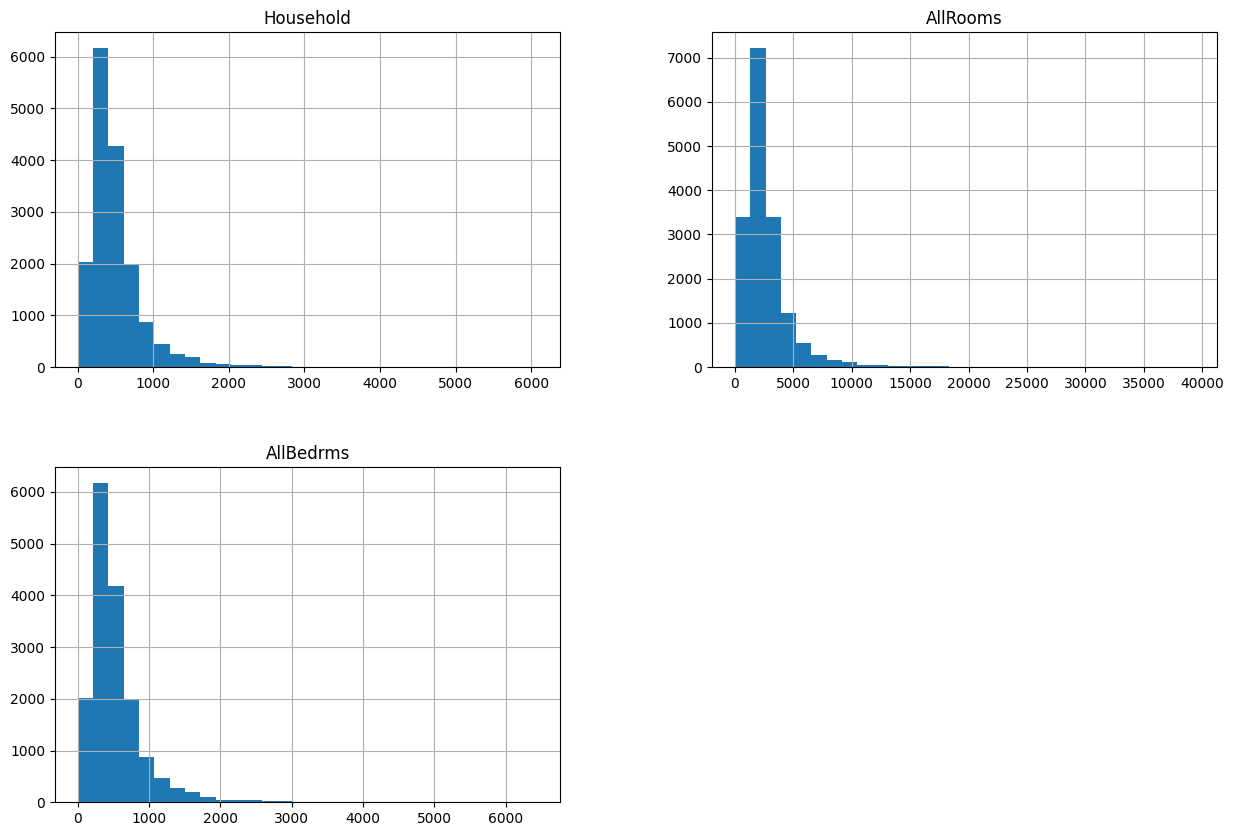

In [47]:
# データの分布を確認
train[['Household', 'AllRooms', 'AllBedrms']].hist(bins=30, figsize=(15, 10))

array([[<Axes: title={'center': 'Household'}>,
        <Axes: title={'center': 'AllRooms'}>],
       [<Axes: title={'center': 'AllBedrms'}>, <Axes: >]], dtype=object)

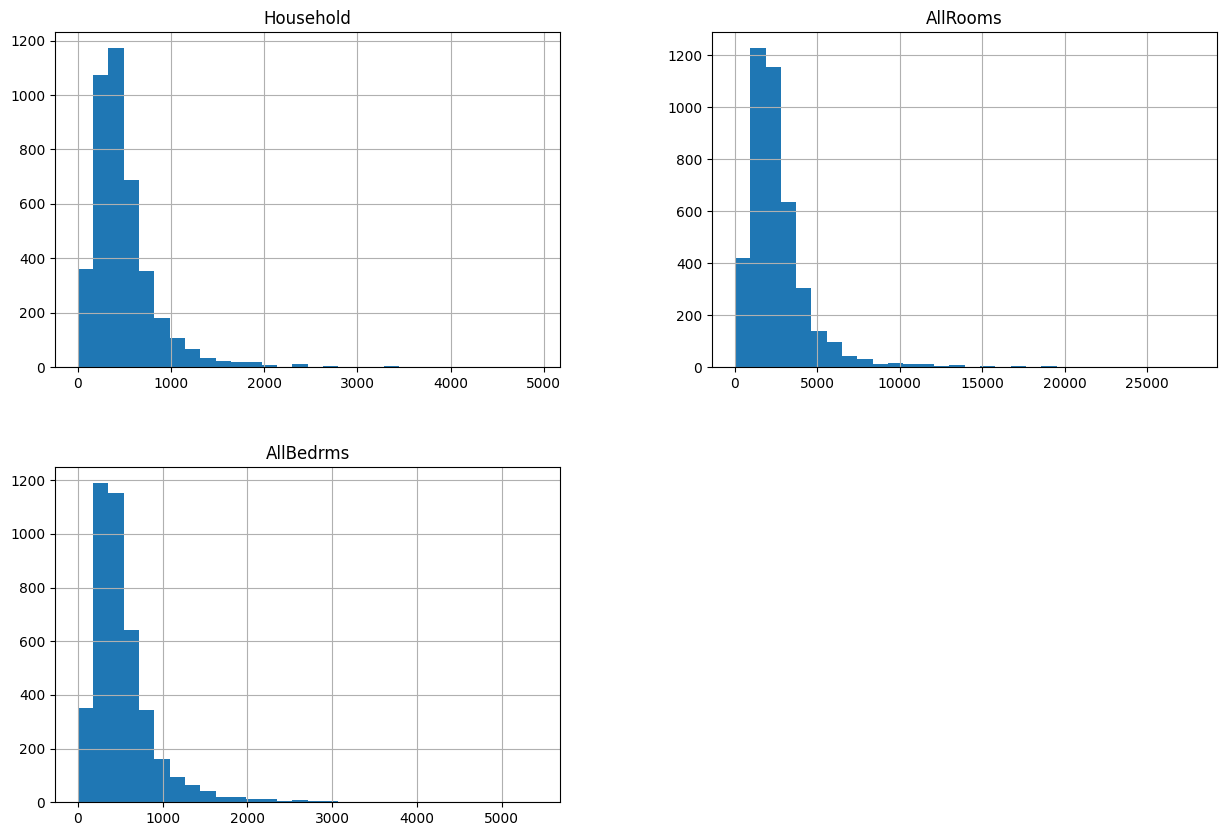

In [48]:
test[['Household', 'AllRooms', 'AllBedrms']].hist(bins=30, figsize=(15, 10))

作成した特徴量についてすべてきれいな整数で出力されました。特に計算も問題なさそうです！  

このように複数の特徴量を組み合わせることで新たな特徴量を作成することができます。   
特徴量生成はデータ分析の成功に大きく寄与する重要な手順です。EDA(探索的データ解析)の段階でデータの特徴や構造を理解し、その特徴に合わせた処理を行うことで機械学習モデルの予測精度を向上させることが期待できます。その他の詳しい手法については添付URLを参考にしてみて下さい！

https://zenn.dev/colum2131/articles/fffac4654e7c7c


## モデルの学習
- 前処理でデータをモデルが読み込める形に加工した後は実際に機械学習を用いて学習を進めていきます。
- データ分析におけるモデルの学習は、機械学習アルゴリズムを用いてデータからパターンや関係性を学習し、予測や分類のタスクに適用するプロセスです。

- モデルの学習では以下の手順で進めます。
  1. **データ分割**： データをトレーニングデータとテストデータに分割します。トレーニングデータはモデルの学習に使用され、テストデータはモデルの性能評価に使用されます。
  2. **モデル選択**：問題に適した機械学習アルゴリズムを選択します。アルゴリズムの選択は、問題のタイプ（回帰、分類、クラスタリングなど）やデータの特性によって決まります。
  3. **学習**：選択したアルゴリズムを使用して、トレーニングデータを用いてモデルを学習させます。このプロセスでは、アルゴリズムがデータセット内のパターンや関係性を捉え、予測や分類を行うための機械学習モデルを構築します。

### データの分割
データを分割することで、モデルが未知のデータに対してどの程度正確に予測や分類ができるかを測定することができます。  
データ分割にはいくつかの方法がありますが、主に以下の3つが一般的です。


  1. **ホールドアウト法**： データセットをトレーニングデータとテストデータに分割します。通常、データセットの70-80%をトレーニングデータに、残りの20-30%をテストデータに割り当てます。トレーニングデータはモデルの学習に使用され、テストデータはモデルの性能評価に使用されます。ホールドアウト法はシンプルで実装が容易ですが、データ分割の仕方によっては偏りが生じる可能性があります。

  2. **k-分割交差検証(k-fold cross-validation)**：データセットをk個の同じサイズのサブセット（フォールド）に分割します。モデルの学習と評価をk回繰り返し、各回で異なるフォールドをテストデータとして使用し、残りのk-1個のフォールドをトレーニングデータとして使用します。最終的にk回の評価結果の平均を取ることで、モデルの性能を推定します。k-分割交差検証は、データの偏りを減らし、モデルの性能評価の信頼性を高めることができますが、計算コストが高くなるというデメリットがあります。

  3. **層化k-分割交差検証(stratified k-fold cross-validation)**： k-分割交差検証と同様に、データセットをk個のサブセットに分割しますが、各フォールドが元のデータセットと同じクラスの比率を持つように分割します。これにより、クラスの不均衡があるデータセットに対しても、各フォールドでクラスの分布が均等になるように保証します。層化k-分割交差検証は、特に分類タスクにおいて、モデルの性能評価の信頼性を高めることができます。ただし、k-分割交差検証と同様に、計算コストが高くなるというデメリットがあります。

**データ分割手法の使い分け**

|手法|使いどころ|
|-|-|
|ホールドアウト法|データセットが大規模でランダムに分布している場合や、計算コストを抑えたい場合|
|k-分割交差検証|データセットが小規模である場合や、データ分布が不均衡でない場合|
|層化k-分割交差検証|データセットがクラスの不均衡がある場合や、分類タスクにおいてクラス間の比率を維持したい場合|

- 今回はホールドアウト法でデータの分割を行います。ホールドアウト法にはscikit learnのtran_test_split関数を用いることができます。

In [49]:
# データを説明変数と目的変数に分ける
train_X = train.drop(['Price', 'id'], axis=1)
target = train['Price']

print('データ分割前の行数' ,len(train_X))

データ分割前の行数 16512


In [50]:
# train_test_splitのimport
from sklearn.model_selection import train_test_split

# データの分割(学習用データ80% 検証用データ 20%)
# test_sizeで検証用データの割合を設定することができる

X_train, X_test, y_train, y_test = train_test_split(train_X, target, test_size=0.2, random_state=2)

# 分割後のデータ数を確認
print('学習用データの行数' ,len(X_train))
print('検証用用データの行数' ,len(X_test))

学習用データの行数 13209
検証用用データの行数 3303


### モデル選択
- データの分割まで終わったので実際に利用するモデルを選択していきます。まずは行いたいタスク(回帰・分類・クラスタリングなど)を選び、その後そのタスクに沿うアルゴリズムを選択します。今回は住宅価格を予測することが目的なので回帰問題となります。  
- その後はデータの分布、特徴量の数、データセットのサイズなど、データの特性を考慮してアルゴリズムの選択を行っていきますが、アルゴリズムの選択方法の基準として利用できるscikit-learnのチートシートがあるのでこれを参考にするのもオススメです。  
- また複数のアルゴリズムで学習を行い、結果的に予測精度が一番高いものを選択する方法も良く用いられます。

今回は単純な線形回帰モデルをpythonで実装しながら見ていきます。

**scikit-learnチートシート**：https://scikit-learn.org/stable/tutorial/machine_learning_map/

### 学習
モデル選択が終わったら、選択したアルゴリズムを使ってトレーニングデータを使ってモデルを学習させましょう！  

scikit-learnでは
  1. **モデルのインスタンス化**
  2. **fit関数を用いて学習**  

の手順で機械学習モデルの学習を手軽に行うことができます。

#### **線形回帰とは**

線形回帰モデル（Linear Regression）は、次のような回帰式を使用して、説明変数から目的変数の値を推定するモデルです。
特に、1つの説明変数を持つ場合は「単回帰分析」と称され、2つ以上の説明変数を含む場合は「重回帰分析」と呼ばれます。

In [51]:
# 線形モデル
from sklearn.linear_model import LinearRegression

# 線形モデルのインスタンス化
LR = LinearRegression()

# 学習の実行
model = LR.fit(X_train, y_train)

## モデルの予測と評価
- モデルの学習が終わったら学習に使ってないデータを用いて予測と予測精度の評価を行います。予測精度の評価をもとにモデルの性能を評価します。評価指標は、解決しようとする問題のタイプ(回帰・分類・クラスタリングなど)によって変わります。

下記に回帰と分類で用いられる代表的な評価指標を紹介します。

#### **回帰の評価指標**


**平均絶対誤差 (MAE)**: 実際の値と予測値の絶対誤差の平均です。

$$
\mathrm{MAE} = \frac{1}{n}\sum_{i=1}^n|y_i - \hat{y}_i|
$$

<br>

**平均二乗誤差 (MSE)**: 実際の値と予測値の二乗誤差の平均です。大きな誤差に対してより厳しい評価を行います。

$$
\mathrm{MSE} = \frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)^2
$$

<br>

**平均二乗誤差平方根 (RMSE)**: MSEの平方根で、誤差の単位が元の目的変数と同じになります。

$$
\mathrm{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)^2}
$$

<br>

**決定係数 (R^2)**: モデルがデータのばらつきをどの程度説明できるかを示す指標です。1に近いほどモデルの性能が良いと評価されます。

$$
R^2 = 1 - \frac{\sum_{i=1}^n(y_i - \hat{y}_i)^2}{\sum_{i=1}^n(y_i - \bar{y})^2}
$$

#### **分類の評価指標**


**混合行列**：分類器が予測したクラスと実際のクラスを比較した結果を示しています。この混合行列をもとに、さまざまな評価指標を計算することができます。

<br>

|                   | Predicted Positive | Predicted Negative |
|-------------------|--------------------|--------------------|
| Actual Positive   | True Positive (TP) | False Negative (FN)|
| Actual Negative   | False Positive (FP)| True Negative (TN) |

<br>

**True Positive(TP)**：真の値が正事例のものに対して、正事例と予測したもの (真陽性)

**False Positive(FP)**：真の値が負事例のものに対して、正事例と予測したもの(偽陽性)

**False Negative(FN)**：真の値が正事例のものに対して、負事例と予測したもの(偽陰性)

**True Negative(TN)**：真の値が負事例のものに対して、負事例と予測したもの(真陰性)

**正解率 (Accuracy)**: 正しく分類されたサンプルの割合です。

$$
\mathrm{Accuracy} = \frac{\mathrm{True \ Positive (TP)} + \mathrm{True \ Negative (TN)}}{\mathrm{True \ Positive (TP)} + \mathrm{True \ Negative (TN)} + \mathrm{False \ Positive (FP)} + \mathrm{False \ Negative (FN)}}
$$

<br>

**適合率 (Precision)**: 正と予測されたサンプルのうち、実際に正であったサンプルの割合です。

$$
\mathrm{Precision} = \frac{\mathrm{True \ Positive (TP)}}{\mathrm{True \ Positive (TP)} + \mathrm{False \ Positive(FP)}}
$$

<br>

**再現率 (Recall)**: 実際に正であったサンプルのうち、正と予測されたサンプルの割合です。

$$
\mathrm{Recall} = \frac{\mathrm{True \ Positive (TP)}}{\mathrm{True \ Positive (TP)} + \mathrm{False \ Negative(FN)}}
$$

<br>

**F1スコア (F1 score)**: 適合率と再現率の調和平均で、両者のバランスを評価する指標です。

$$
\mathrm{F1 \ Score} = 2 \times \frac{\mathrm{Precision} \times \mathrm{Recall}}{\mathrm{Precision} + \mathrm{Recall}}
$$

今回は回帰の評価指標MAE、MSE、RMSE、決定係数の4種類でモデルの性能を確認してみます。

In [52]:
# 評価指標のimport
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# モデルの予測 学習済みモデルを使用して、新しいデータに対して予測を行うために、predict関数を利用できます。
pred = model.predict(X_test)

# MAE
print('MAE',mean_absolute_error(y_test, pred))
print('-' * 50)

# MSE
print('MSE',mean_squared_error(y_test, pred))
print('-' * 50)

# RMSE RMSEはMSEに√を付けたものになるのでnp.sqrt()でMSEを囲んで算出する
print('RMSE',np.sqrt(mean_squared_error(y_test, pred)))
print('-' * 50)

# 決定係数
print('決定係数',r2_score(y_test, pred))

MAE 0.4999946441433737
--------------------------------------------------
MSE 0.46874164044625827
--------------------------------------------------
RMSE 0.6846470918993656
--------------------------------------------------
決定係数 0.6440681200241893


決定係数からこのモデルはモデルはデータのバリエーションの60%を説明できるということが読み取れます。  
実際のデータ分析では、ここからモデルのチューニングやより良い特徴量の作成、他のモデルを利用するなどして予測精度が向上するように試行錯誤を繰り返していきます。

## モデルのチューニング
- モデルの性能を上げるためにハイパーパラメータや特徴量の調整します。チューニングの手法として主に以下が挙げられます。

  1. **ハイパーパラメータチューニング**：ハイパーパラメータは、モデルの学習プロセスに影響を与えるパラメータです。ハイパーパラメータは学習データから自動的に決定されず、事前に設定する必要があります。適切なハイパーパラメータを選択することで、モデルの性能が向上することがあります。ハイパーパラメータチューニングの一般的な手法には、グリッドサーチ、ランダムサーチ、ベイズ最適化などがあります。

  2. **特徴量選択**：特徴量選択は、モデルの性能に寄与する特徴量を選択し、不要な特徴量を削除するプロセスです。これにより、モデルの過学習を防ぎ、計算効率を向上させることができます。

  3. **アンサンブル学習**：アンサンブル学習は、複数のモデルを組み合わせて、より強力な予測モデルを構築する手法です。バギング、ブースティング、スタッキングなどが代表的なアンサンブル学習の方法です。アンサンブル学習により、モデルのバリアンスやバイアスを低減し、性能を向上させることができます。

  4. **正則化**：正則化は、モデルの過学習を防ぐために、モデルの複雑さにペナルティを課す手法です。L1正則化（Lasso回帰）やL2正則化（Ridge回帰）などが一般的です。正則化は、モデルが学習データに過剰に適合するのを防ぎ、汎化性能を向上させます。
  5. **後処理**：モデルによって生成された予測結果を、実際の問題やアプリケーションに適用するために調整するプロセスです。出力値の範囲を指定してデータを丸め込んだり、分類問題の場合は確率の閾値を調整することで評価指標に対して最適化を行うことができます。


- 今回はモデルの予測値の最小値を0、最大値を5.00001に丸め込む後処理とアンサンブル学習を行うことでモデルの性能がどれほど向上するのかを確認してみます！

### 後処理
- 機械学習における後処理は、モデルが生成した出力に対して、追加の処理を行い、予測結果の品質を向上させる重要なステップです。後処理には、次のような手法があります。

  1. **しきい値の調整**: 二値分類問題において、確率のしきい値を調整することで、適合率と再現率のバランスを最適化します。
  
  2. **カットオフ**: 回帰問題において、予測値の最小値や最大値を制限することで、予測範囲を実際の問題に合わせます。

In [53]:
print('最小値',min(pred))
print('最大値',max(pred))

最小値 -1.2581464319465923
最大値 6.907609739170908


線形回帰による予測値の範囲は、上記の通りです。  
ただし、住宅価格がマイナスになることはあり得ないため、0以下の予測値が出力された場合は、0に置き換えるように処理します。  
また、住宅価格の最大値が5.00001であることが判明しているため、それ以上の値が出力された場合は、5.00001に変換するように処理します。

In [54]:
# 数値の丸め込み処理 0以下を0に5.00001以上を5.00001に変換する
pred_rounding = np.where(pred <= 0, 0, pred)
pred_rounding = np.where(pred_rounding >= 5.00001, 5.00001, pred_rounding)

print('最小値',min(pred_rounding))
print('最大値',max(pred_rounding))

最小値 0.0
最大値 5.00001


In [55]:
# 後処理後の評価指標を確認

# MAE
print('MAE_後処理前',mean_absolute_error(y_test, pred))
print('MAE_後処理後',mean_absolute_error(y_test, pred_rounding))
print('-' * 50)

# MSE
print('MSE_後処理前',mean_squared_error(y_test, pred))
print('MSE_後処理後',mean_squared_error(y_test, pred_rounding))
print('-' * 50)

# RMSE
print('RMSE_後処理前',np.sqrt(mean_squared_error(y_test, pred)))
print('RMSE_後処理後',np.sqrt(mean_squared_error(y_test, pred_rounding)))
print('-' * 50)

# 決定係数
print('決定係数_後処理前',r2_score(y_test, pred))
print('決定係数_後処理後',r2_score(y_test, pred_rounding))

MAE_後処理前 0.4999946441433737
MAE_後処理後 0.49152645279254525
--------------------------------------------------
MSE_後処理前 0.46874164044625827
MSE_後処理後 0.4532976691185877
--------------------------------------------------
RMSE_後処理前 0.6846470918993656
RMSE_後処理後 0.6732738440772726
--------------------------------------------------
決定係数_後処理前 0.6440681200241893
決定係数_後処理後 0.6557952662271955


後処理によって、評価指標がわずかに改善されることが確認できました！  
目的変数の特徴を事前に把握しておくことで、適切な後処理が可能になります。

### アンサンブル学習
**アンサンブル学習**：複数のモデルを組み合わせることで予測性能を向上させる手法。主に下記の3つがあります。


  1. **バギング（Bagging）**: バギング（Bootstrap Aggregating）は、学習データからランダムに復元抽出（ブートストラップサンプリング）を行い、それぞれのサンプルでモデルを学習させます。これにより、異なるデータセットで学習された複数のモデルが生成されます。最終的な予測は、各モデルの予測結果を平均（回帰）または多数決（分類）で決定します。バギングは、モデルの過学習を抑制し、性能の向上を目指します。

  2. **ブースティング（Boosting）**: ブースティングは、弱学習器（性能がやや低いモデル）を逐次的に学習させ、それらの結果を組み合わせることで強力な予測モデルを作成する方法です。ブースティングでは、前の学習器の誤りを次の学習器が修正するように学習が進みます。これにより、弱学習器の連続的な改善が行われ、全体の予測性能が向上します。代表的なブースティングアルゴリズムには、AdaBoostやGradient Boostingなどがあります。

  3. **スタッキング（Stacking）**: スタッキングは、異なる種類のモデル（ベースモデル）を組み合わせて予測性能を向上させる方法です。各ベースモデルの予測結果を、新たな学習データとして用いて、メタモデル（次のレベルのモデル）が学習されます。このメタモデルが、最終的な予測を行います。スタッキングは、異なるアルゴリズムやパラメータ設定を持つモデルの予測結果を効果的に組み合わせることで、性能の向上を目指します。

アンサンブル学習のメリットとデメリット
- **メリット**

  1. **予測性能の向上**：複数のモデルの組み合わせにより、単一のモデルよりも高い予測性能が得られることが多いです。

  2. **過学習の抑制**：バギングやブースティングにより、モデルの過学習を抑制し、汎化性能を向上させることができます。

  3. **モデルの多様性**：スタッキングでは、異なる種類のモデルやアルゴリズムを組み合わせることで、予測結果に対する多様性を持たせることができます。これにより、モデルが特定の問題に対して偏らず、より一般的な問題に対処できるようになります。


- **デメリット**

  1. **計算コストの増加**：複数のモデルを学習し、予測結果を組み合わせるため、計算コストが増加します。

  2. **モデルの複雑性**：アンサンブルモデルは、個別のモデルよりも複雑になることがあり、解釈性が低下することがあります。

今回は、Kaggleでもよく使用されるブースティング手法であるxgboostを試してみたいと思います！

公式ドキュメント：https://xgboost.readthedocs.io/en/stable/

In [56]:
# xgboostのimport
from xgboost import XGBRFRegressor

# xgboostのインスタンス化
XGBoost = XGBRFRegressor()

# 学習の実行
model = XGBoost.fit(X_train, y_train)

# モデルの予測 学習済みモデルを使用して、新しいデータに対して予測を行うために、predict関数を利用できます。
pred_xg = model.predict(X_test)

# 数値の丸め込み処理 0以下を0に5.00001以上を5.00001に変換する
pred_xg_rounding = np.where(pred_xg <= 0, 0, pred_xg)
pred_xg_rounding = np.where(pred_xg_rounding >= 5.00001, 5.00001, pred_xg_rounding)


# MAE
print('MAE_線形回帰',mean_absolute_error(y_test, pred_rounding))
print('MAE_xgboost',mean_absolute_error(y_test, pred_xg_rounding))
print('-' * 50)

# MSE
print('MSE_線形回帰',mean_squared_error(y_test, pred_rounding))
print('MSE_xgboost',mean_squared_error(y_test, pred_xg_rounding))
print('-' * 50)

# RMSE RMSEはMSEに√を付けたものになるのでnp.sqrt()でMSEを囲んで算出する
print('RMSE_線形回帰',np.sqrt(mean_squared_error(y_test, pred_rounding)))
print('RMSE_xgboost',np.sqrt(mean_squared_error(y_test, pred_xg_rounding)))
print('-' * 50)

# 決定係数
print('決定係数_線形回帰',r2_score(y_test, pred_rounding))
print('決定係数_xgboost',r2_score(y_test, pred_xg_rounding))

MAE_線形回帰 0.49152645279254525
MAE_xgboost 0.44581841527249355
--------------------------------------------------
MSE_線形回帰 0.4532976691185877
MSE_xgboost 0.37652226452619836
--------------------------------------------------
RMSE_線形回帰 0.6732738440772726
RMSE_xgboost 0.6136141006578959
--------------------------------------------------
決定係数_線形回帰 0.6557952662271955
決定係数_xgboost 0.714093509298702


xgboostを使うことで予測精度が向上していることが確認できました。  
xgboostなどの勾配ブースティング決定木アルゴリズムは他のアルゴリズムと比較して予測精度が高い傾向があり、データに欠損値が存在する場合でも予測を行うことができるのでkaggleなどのデータ分析コンペではよく利用されています。実際のコンペでの実装例はkaggleのnotebookなどで確認することができるのでより深く知りたい場合は参考にしてみてください！

## 提出用notebookの作成(コンペ用)

In [57]:
# ハイパーパラメータ(この値を調整して精度がどのようになるか見てみよう！)

max_depth = 6           #決定木の深さの最大値(大きいほど過学習寄り)
subsample = 0.7         #各決定木においてランダムに抽出される標本の割合(大きいほど過学習寄り)   
min_child_weight = 0.5  #決定木の葉の重みの下限(小さいほど過学習寄り)
colsample_bytree = 0.9  #各決定木においてランダムに抽出される列の割合
learning_rate = 0.2     #過学習防止のための学習率パラメータ(大きいほど過学習寄り)

In [58]:
# xgboostのimport
from xgboost import XGBRFRegressor

# xgboostのインスタンス化
XGBoost = XGBRFRegressor(
    max_depth=max_depth,
    subsample=subsample,
    min_child_weight=min_child_weight,
    colsample_bytree=colsample_bytree,
    learning_rate=learning_rate
)

# 学習の実行
model = XGBoost.fit(X_train, y_train)

# モデルの予測 学習済みモデルを使用して、新しいデータに対して予測を行うために、predict関数を利用できます。
pred_xg = model.predict(X_test)

# 数値の丸め込み処理 0以下を0に5.00001以上を5.00001に変換する
pred_xg_rounding = np.where(pred_xg <= 0, 0, pred_xg)
pred_xg_rounding = np.where(pred_xg_rounding >= 5.00001, 5.00001, pred_xg_rounding)

In [59]:
# id列の削除
test_X = test.drop(['id'],axis=1)

# モデルの予測 学習済みモデルを使用して、新しいデータに対して予測を行うために、predict関数を利用できます。
pred_xg = model.predict(test_X)

# 数値の丸め込み処理 0以下を0に5.00001以上を5.00001に変換する
pred_xg_rounding = np.where(pred_xg <= 0, 0, pred_xg)
pred_xg_rounding = np.where(pred_xg_rounding >= 5.00001, 5.00001, pred_xg_rounding)

In [60]:
# sampleに予測値の代入と提出ファイルの作成
sample['Price'] = pred_xg_rounding
sample

,id,Price
0,0,0.993988
1,1,0.772024
2,2,0.665041
3,3,1.042682
4,4,1.154701
...,...,...
4123,4123,0.846892
4124,4124,0.581993
4125,4125,0.701261
4126,4126,0.639316


In [61]:
sample.to_csv('submit.csv',index=None)